In [1]:
import json
import modin.pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
sys.path.insert(0,'/media/csivsw/crossOS/playground/friends_of_tracking/src/friends_of_tracking/LaurieOnTracking')
%matplotlib inline

In [2]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel

In [3]:
# set up initial path to data
DATADIR = '../datahub/metrica_sports/sample-data/data'
game_id = 2 # let's look at sample match 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# read in tracking data
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = mio.to_single_playing_direction(tracking_home,tracking_away,events)


Reading team: home
Reading team: away


In [4]:
# Calculate player velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True)
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True)

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68d0b49320>)

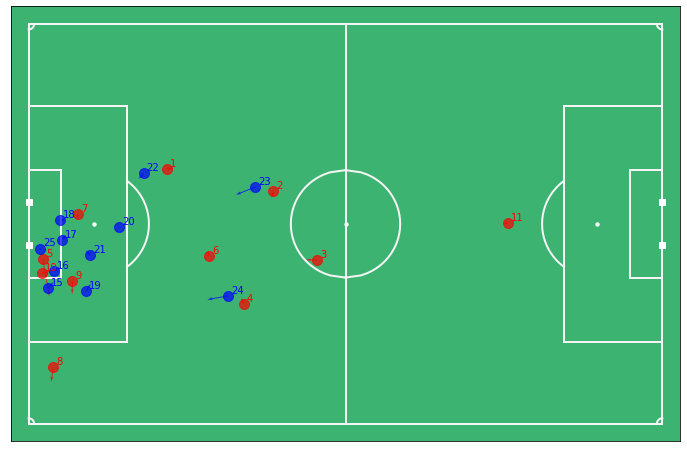

In [5]:
# plot a random frame, plotting the player velocities using quivers
mviz.plot_frame( tracking_home.loc[10000], tracking_away.loc[10000], include_player_velocities=True, annotate=True)


In [6]:
from collections import namedtuple

In [7]:
point = namedtuple('point',['x','y'])
centre = point(0.,0)
centre

point(x=0.0, y=0)

In [8]:
%matplotlib inline

In [9]:
import plotly.graph_objects as go
import plotly.figure_factory as ff


In [201]:
def plot_pitch(field_dimen = (106.0,68.0), field_color ='green', linewidth=2, markersize=20, data = None):
    # decide what color we want the field to be. Default is green, but can also choose white
#     if field_color=='green':
#         ax.set_facecolor('mediumseagreen')
#         lc = 'whitesmoke' # line color
#         pc = 'w' # 'spot' colors
#     elif field_color=='white':
#         lc = 'k'
#         pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1] 
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    centre = point(0.,0.)
    
    
    shapes = []
    
    mid_circle = dict(type="circle", x0=centre.x - centre_circle_radius, y0=centre.y - centre_circle_radius, x1=centre.x + centre_circle_radius, y1=centre.y + centre_circle_radius, line_color="White", layer = "below") 
    mid_line = dict(type="line",
                    x0=centre.x, y0=centre.y - half_pitch_width,
                    x1=centre.x, y1=centre.y + half_pitch_width, line_color="White", layer = "below")
    mid_point = dict(type="circle", 
                     x0=centre.x-0.4, y0=centre.y-0.4, 
                     x1=centre.x+0.4, y1=centre.y+0.4, line_color="White", fillcolor='white', layer = "below") 
    shapes.extend([mid_circle,mid_line,mid_point])
    
    
    for s in signs:
        
        # plot pitch boundary
        boundary1 = dict(type="line",
                    x0=-half_pitch_length, y0=s*half_pitch_width,
                    x1=half_pitch_length, y1=s*half_pitch_width, line_color="White", layer = "below")
        
        boundary2 = dict(type="line",
                    x0=s*half_pitch_length, y0=-half_pitch_width,
                    x1=s*half_pitch_length, y1=half_pitch_width, line_color="White", layer = "below")
        
        circle = dict(type="circle", 
                           x0=s*(centre.x+half_pitch_length-penalty_spot) - centre_circle_radius, y0=centre.y - centre_circle_radius,
                           x1=s*(centre.x+half_pitch_length-penalty_spot) + centre_circle_radius, y1=centre.y + centre_circle_radius, line_color="White", layer = "below")
        
        patch = dict(type="rect",
                     x0=s*half_pitch_length,y0=-area_width/2. - 1,
                     x1=s*(half_pitch_length - area_length),y1=area_width/2. + 1,line=dict(color="mediumseagreen",width=0),fillcolor="mediumseagreen", layer = "below")
        
        box = dict(type="rect",
                              x0=s*half_pitch_length,y0=-area_width/2.,
                              x1=s*(half_pitch_length - area_length),y1=area_width/2.,line=dict(color="white",width=2), layer = "below")
        D = dict(type="rect",
                 x0=s*half_pitch_length,y0=-box_width/2.,
                 x1=s*(half_pitch_length - box_length),y1=box_width/2.,line=dict(color="white",width=2), layer = "below")
        pen = dict(type="circle", 
                   x0=s*(half_pitch_length - penalty_spot)-0.4, y0=-0.4, 
                   x1=s*(half_pitch_length - penalty_spot)+0.4, y1= 0.4, line_color="White", fillcolor='white', layer = "below")

        top_post = dict(type="rect", 
                        x0=s*half_pitch_length, y0=goal_line_width/2. - 0.5, 
                        x1=s*(half_pitch_length-0.5), y1=goal_line_width/2.+0.5, line=dict(color="white",width=0),fillcolor="white", layer = "below")
        
        bottom_post = dict(type="rect", 
                        x0=s*half_pitch_length, y0=-goal_line_width/2. - 0.5, 
                        x1=s*(half_pitch_length-0.5), y1=-goal_line_width/2.+0.5, line=dict(color="white",width=0),fillcolor="white", layer = "below")
        
        shapes.extend([boundary1, boundary2,circle, patch , box, D, pen, top_post, bottom_post])
        
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    
    layout = go.Layout(
                    title='Plotting frames and events using Plotly',
                    hovermode='closest',
                    autosize=False,
                    width=1200,
                    height=800,
                    plot_bgcolor='mediumseagreen',
                    xaxis=go.layout.XAxis(
                        range=[-xmax, xmax],
                        showgrid=False,zeroline=False,
                        showticklabels=False
                    ),
                    yaxis=go.layout.YAxis(
                        range=[-ymax, ymax],
                        showgrid=False,zeroline=False,
                        showticklabels=False,
                        scaleanchor = "x",
      scaleratio = 1,
                ),
    shapes=shapes)
    data = data

    fig = go.Figure(data= data, layout=layout)
    
    return fig

In [28]:
player_marker_props = ['color': home.color, 'size', 'linecolor','linewidth', 'annotation': 'num','size']


# get nums of home players
# get each player namedtuple 


# plot a frame
# -- plot pitch
# -- plot home player pos / vel / pitch-ctrl?
# -- plot away player pos / vel / pitch-ctrl?
# -- plot ball


# save match clip
# -- plot a frame
# -- include match time at top
# ^^ iterate from all the indices 
# >> save animation

# plot events
# -- plot pitch
# -- plot event row action

SyntaxError: invalid syntax (<ipython-input-28-54d2b3fd9c8c>, line 1)

In [147]:
PLAYERMARKERSIZE = 20
player_marker_args = {'Home': dict(mode='markers+text', 
                                   marker_size = PLAYERMARKERSIZE, 
                                   marker_line_color="white", 
                                   marker_color="red", 
                                   marker_line_width=2,
                                   textfont=dict(
                                        size=11,
                                        color="white"
                                    )),
                      'Away': dict(mode='markers+text', 
                                   marker_size = PLAYERMARKERSIZE, 
                                   marker_line_color="white", 
                                   marker_color="#0570b0", 
                                   marker_line_width=2,
                                   textfont=dict(
                                        size=11,
                                        color="white"
                                    ))}

event_player_marker_args = {'Home': dict(mode='lines+markers+text', 
                                   marker_size = PLAYERMARKERSIZE, 
                                   marker_line_color="white", 
                                   marker_color="red", 
                                   marker_line_width=2,
                                   line_color = "red",
                                   textfont=dict(
                                        size=11,
                                        color="white"
                                    )),
                      'Away': dict(mode='lines+markers+text', 
                                   marker_size = PLAYERMARKERSIZE, 
                                   marker_line_color="white", 
                                   marker_color="#0570b0", 
                                   marker_line_width=2,
                                   line_color ="#0570b0",
                                   textfont=dict(
                                        size=11,
                                        color="white"
                                    ))}


In [196]:


def positions(tracking_data):
    position_traces = []
    for i, side in enumerate(['Home','Away']):
        team_data = tracking_data[i]
        player_nums = list(set(item for subitem in team_data.keys() for item in subitem.split('_')
                               if item.isdigit()))
        xlocs = [team_data['{}_{}_{}'.format(side, num,'x')] for num in player_nums]
        ylocs = [team_data['{}_{}_{}'.format(side, num,'y')] for num in player_nums]
        traces = go.Scatter(x = xlocs,y = ylocs, text = player_nums, **player_marker_args[side], name = side)
        position_traces.append(traces)

    return position_traces


def velocities(tracking_data):
    velocity_quivers = []
    for i, side in enumerate(['Home','Away']):
        team_data = tracking_data[i]
        player_nums = list(set(item for subitem in team_data.keys() for item in subitem.split('_')
                               if item.isdigit()))
        xlocs = [team_data['{}_{}_{}'.format(side, num,'x')] for num in player_nums]
        ylocs = [team_data['{}_{}_{}'.format(side, num,'y')] for num in player_nums]
        xvels = [team_data['{}_{}_{}'.format(side, num,'vx')] for num in player_nums]
        yvels = [team_data['{}_{}_{}'.format(side, num,'vy')] for num in player_nums]
        trace = ff.create_quiver(x = xlocs, y = ylocs, u = xvels,v = yvels, 
                                 scale=1., line_color = player_marker_args[side]['marker_color'], name = side+'_vel')
        velocity_quivers.append(trace.data[0])

    return velocity_quivers



def plot_ball(tracking_data):
    team_data = tracking_data[0]
    trace = go.Scatter(x = [team_data['ball_x']],y = [team_data['ball_y']], 
                           marker_size = 10, marker_opacity=0.8, marker_color = '#262e39', name = 'ball'
                          )
    return [trace]

In [197]:
def plot_frame(hometeam, awayteam, show_velocities=True):
    tracking_data = (hometeam,awayteam)
    traces = []
    
    if show_velocities: traces.extend(velocities(tracking_data))
        
    traces.extend(positions(tracking_data))
    
    if hometeam['ball_x']: traces.extend(plot_ball(tracking_data))
        
    fig = plot_pitch(data=traces)
    fig.show()

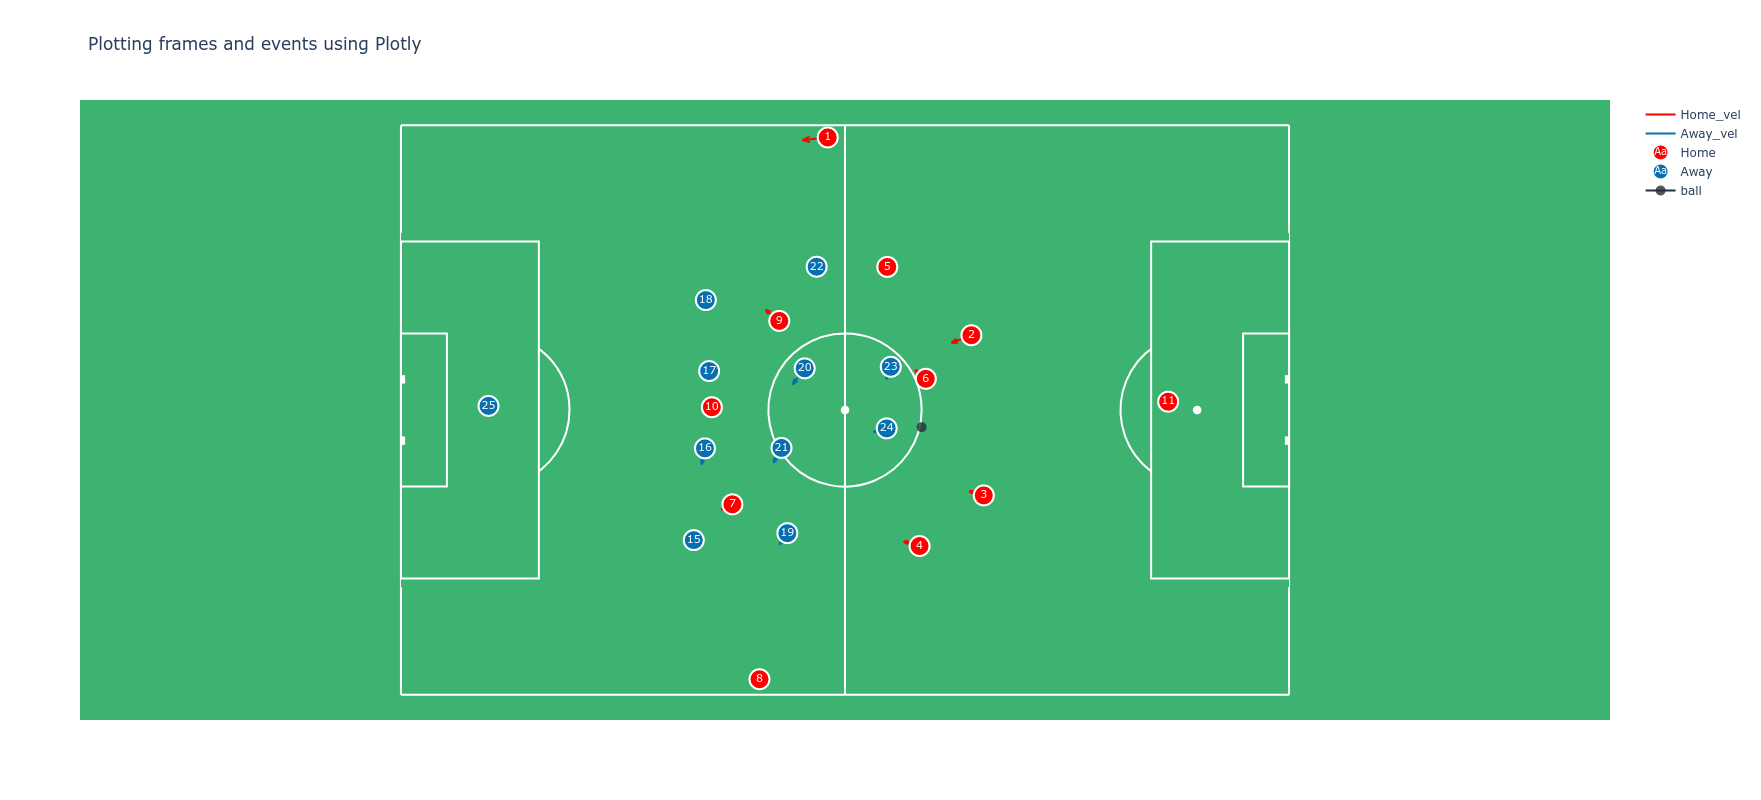

In [202]:
hometeam = tracking_home.loc[9000]
awayteam = tracking_away.loc[9000]
plot_frame(hometeam, awayteam)

In [48]:
# plot event
DATADIR = '../datahub/metrica_sports/sample-data/data/'
game_id = 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)
# Bit of housekeeping: unit conversion from metric data units to meters
events = mio.to_metric_coordinates(events)

# Get events by team
home_events = events.query("Team=='Home'")
away_events = events.query("Team=='Away'")

# Get all shots
shots = events.query("Type=='SHOT'")
home_shots = home_events.query("Type=='SHOT'")
away_shots = away_events.query("Type=='SHOT'")

# Get the shots that led to a goal
home_goals = home_shots.query("Subtype.str.endswith('GOAL')").copy()
away_goals = away_shots.query("Subtype.str.endswith('GOAL')").copy()

# Add a column event 'Minute' to the data frame
home_goals['Minute'] = home_goals['Start Time [s]']/60.



In [49]:
events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44


In [50]:
# first goal
events.query("Type=='SHOT' & Subtype.str.endswith('GOAL')")

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,47.70,-1.36,54.06,-2.04
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,-40.28,-1.36,-55.12,-2.72
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,30.74,-5.44,54.06,-2.72


In [182]:
def get_goal_lead_up(goal_id,events):
    for i,row in events.iloc[goal_id-1::-1,:2].iterrows():
        if row['Type']!='PASS':
            break
    return events.iloc[i+1:goal_id+1,:]

get_goal_lead_up(198,events)

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
190,Home,PASS,NaN,1,11647,465.88,11685,467.40,Player7,Player10,-13.78,-0.68,-21.20,-0.00
191,Home,PASS,NaN,1,11685,467.40,11703,468.12,Player10,Player5,-21.20,-0.00,-18.02,4.08
192,Home,PASS,NaN,1,11721,468.84,11744,469.76,Player5,Player9,-20.14,4.08,-30.74,7.48
193,Home,PASS,NaN,1,11810,472.40,11885,475.40,Player9,Player8,-32.86,0.68,-39.22,-25.16
194,Home,PASS,NaN,1,11958,478.32,11976,479.04,Player8,Player9,-41.34,-24.48,-42.40,-14.96
195,Home,PASS,NaN,1,11976,479.04,11994,479.76,Player9,Player8,-42.40,-14.96,-38.16,-20.40
196,Home,PASS,NaN,1,12069,482.76,12146,485.84,Player8,Player1,-28.62,-7.48,-37.10,23.80
197,Home,PASS,CROSS,1,12180,487.20,12202,488.08,Player1,Player10,-40.28,19.72,-47.70,-3.40
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04


In [192]:
buildup = get_goal_lead_up(823,events)
buildup['From_num'] = buildup.From.apply(lambda x: re.findall('\d+',str(x))).apply(lambda x: x[0] if len(x)>0 else None)
buildup['To_num'] = buildup.To.apply(lambda x: re.findall('\d+',str(x))).apply(lambda x: x[0] if len(x)>0 else None)
buildup['To_prev'] = buildup.To_num.shift(1)
buildup['Start X Carry'] = buildup['End X']
buildup['End X Carry'] = buildup['Start X'].shift(-1)
buildup['Start Y Carry'] = buildup['End Y']
buildup['End Y Carry'] = buildup['Start Y'].shift(-1)
buildup['carry'] =(buildup['Start X Carry']!=buildup['End X Carry']) | (buildup['Start Y Carry']!=buildup['End Y Carry'])
buildup.loc[buildup['carry'] == False,'Start X Carry'] = np.nan; buildup.loc[buildup['carry'] == False,'Start Y Carry'] = np.nan
buildup.loc[buildup['carry'] == False,'End X Carry'] = np.nan; buildup.loc[buildup['carry'] == False,'End Y Carry'] = np.nan

buildup['Start Frame Carry'] = buildup['End Frame']
buildup['End Frame Carry'] = buildup['Start Frame'].shift(-1)


buildup

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,From_num,To_num,To_prev,Start X Carry,End X Carry,Start Y Carry,End Y Carry,carry,Start Frame Carry,End Frame Carry
818,Away,PASS,HEAD,1,52696,2107.84,52746,2109.84,Player17,Player18,-1.06,7.48,-5.30,18.36,17,18,NaN,-5.30,-3.18,18.36,22.44,True,52746,52784.0
819,Away,PASS,NaN,1,52784,2111.36,52807,2112.28,Player18,Player21,-3.18,22.44,1.06,12.24,18,21,18,1.06,2.12,12.24,12.92,True,52807,52871.0
820,Away,PASS,NaN,1,52871,2114.84,52936,2117.44,Player21,Player19,2.12,12.92,30.74,-26.52,21,19,21,30.74,30.74,-26.52,-27.20,True,52936,52941.0
821,Away,PASS,NaN,1,52941,2117.64,52971,2118.84,Player19,Player23,30.74,-27.20,37.10,-15.64,19,23,19,37.10,41.34,-15.64,-9.52,True,52971,53027.0
822,Away,PASS,NaN,1,53027,2121.08,53045,2121.80,Player23,Player24,41.34,-9.52,44.52,2.72,23,24,23,NaN,NaN,NaN,NaN,False,53045,53049.0
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36,24,None,24,54.06,NaN,1.36,NaN,True,53075,NaN


In [193]:
def event_trace(row):
    traces = []
    x,y,player_nums = [],[],[]
    x.extend([row['Start X'],row['End X']])
    y.extend([row['Start Y'],row['End Y']])
    side = row['Team']
    player_nums.extend([row['From_num'],row['To_num']])
        
    traces.append(go.Scatter(x = x,y = y, 
                        text = player_nums,
                        **event_player_marker_args[side]
                       ))
    
    if (row['Type'] == 'PASS') & (row['carry']==True):
        traces.append(go.Scatter(x = [row['Start X Carry'],row['End X Carry']],y = [row['Start Y Carry'],row['End Y Carry']], 
                        text = [row['To_num']],line_dash ='dash',
                        **event_player_marker_args[side]
                       ))
        
        
#     print (traces)
    return traces

In [194]:
def plot_events(event_chain, hometeam, awayteam, show_velocities=True):
    tracking_data = (hometeam,awayteam)
    traces = []
    for i,row in event_chain.iterrows():
#         print (event_trace(row))
        traces.extend(event_trace(row))
    
    
    
#     if show_velocities: traces.extend(velocities(tracking_data))
        
#     traces.extend(positions(tracking_data))
    
#     if hometeam['ball_x']: traces.extend(plot_ball(tracking_data))
#     print (traces)   
    fig = plot_pitch(data=traces)
    fig.show()

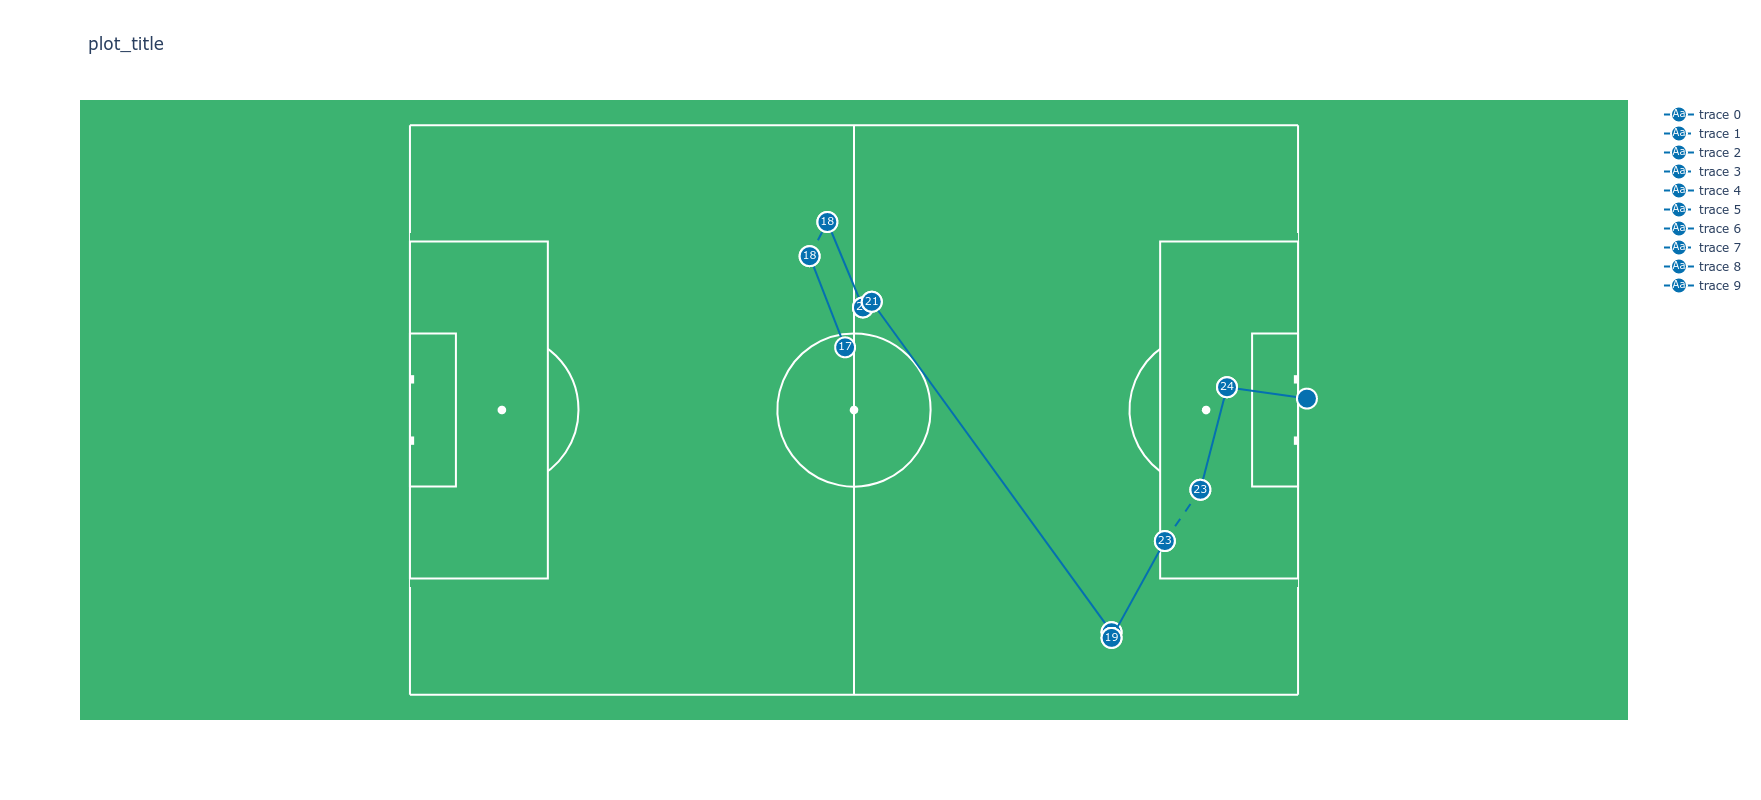

In [195]:
plot_events(buildup, hometeam, awayteam, show_velocities=True)

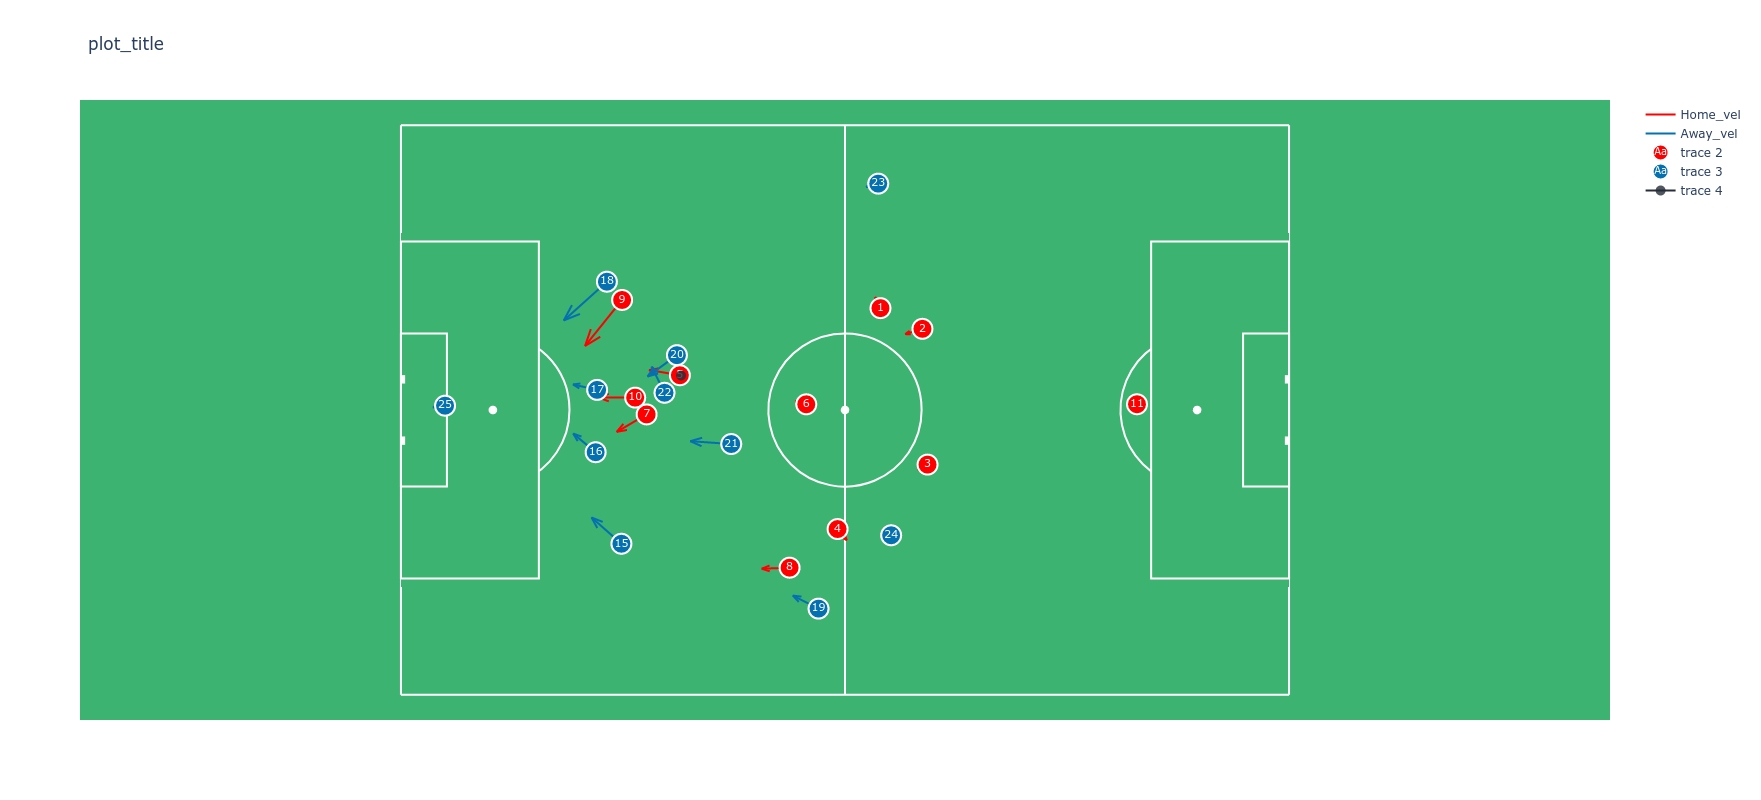

In [53]:
frame = 11717
hometeam = tracking_home.loc[frame]
awayteam = tracking_away.loc[frame]
plot_frame(hometeam, awayteam)

In [ ]:
# Plot the first goal
fig,ax = mviz.plot_pitch()
ax.plot( events.loc[198]['Start X'], events.loc[198]['Start Y'], 'ro' )
ax.annotate("", xy=events.loc[198][['End X','End Y']], 
            xytext=events.loc[198][['Start X','Start Y']], 
            alpha=0.6, arrowprops=dict(arrowstyle="->",color='r'));

# plot passing move in run up to goal
mviz.plot_events(events.loc[190:198], indicators = ['Marker','Arrow'], 
                 annotate=True, figax=(fig,ax))